While it is instructive to think about tracking the propagation history of
photons when illustrating the basic idea behind Monte Carlo radiative transfer
techniques, there are important numerical reasons for using a different
discretization scheme. Instead of thinking in the photon picture, it brings
significant advantages to follow the idea of <strong data-cite="Abbott1985">[AbbottLucy85]</strong> and
<strong data-cite="Lucy1999">[Lucy99a]</strong> and consider parcels of radiant energy as the fundamental
building blocks of the Monte Carlo calculation. These basic Monte Carlo quanta
are commonly referred to as "energy packets" or simply "packets".

During a Monte Carlo calculation, a large number of packets, all with a certain
energy $\varepsilon$, are created. In addition, each packet is associated
with a frequency. These assignments are performed in a manner which ensures
that the ensemble of packets represents the spectral energy distribution of the
radiation field.

During the simulation, the energy of the packet remains constant in the local
co-moving frame (see [Reference Frames](propagation.rst#reference-frames) for
details about the lab and co-moving frames). This naturally ensures energy
conservation and constitutes the main advantage of this discretization scheme.
There is one side effect of this so-called indivisible packet energy scheme
which often causes confusion: Even during radiation-matter interactions the
packet energy is conserved in the co-moving frame (see [Packet Propagation](propagation.rst)). However, the frequency associated with a packet may change
(e.g. during non-resonant line interactions). As a consequence, packets may
represent a varying number of real photons during their lifetime.

.. note::
    The indivisible energy packet scheme does not require that all packets have
    the same energy. This is just a convenient and simple choice adopted in
    TARDIS.

In [1]:
import numpy as np
from tardis.montecarlo.packet_source import *
from tardis import constants as const
import matplotlib.pyplot as plt

#The random number generator that will be used
rng = np.random.default_rng()

[py.warnings         ][WARNING]  /home/isaac/tardis-sn/tardis/montecarlo/montecarlo_numba/formal_integral.py:177: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @jitclass(integrator_spec)
 (warnings.py:110)


The followig cell contains values that you can change to see how it affects the spectrum:

In [2]:
seed = 42069 #seed for the pseudo-random number generator
r_photosphere = 847.38 #radius of the supernova's photosphere in cm
n_packets = 40000 #number of packets generated

You can either set a temperatature of the photosphere, which will determine its luminosity; or you can set the luminosity of the photosphere, which will determine it's temperature.

In [3]:
temp = 10000 #temperature in K
lumin = 4 * np.pi * (r_photosphere**2) * const.sigma_sb.cgs.value * (temp**4)
print('Luminosity:',lumin,'erg/s')

Luminosity: 5.11655811094159e+18 erg/s


In [ ]:
lumin = 1113 #luminocity in erg/s
temp = ( lumin / (4 * np.pi * const.sigma_sb.cgs.value) )**0.25 / np.sqrt(r_photosphere)
print('Temperature:',temp,'K')

We now generate the ensemble of packets. The array of packet energies is also shown.

In [4]:
nus,mus,energies = BlackBodySimpleSource(seed).create_packets(temp,n_packets,rng)

print(energies)

[2.5e-05 2.5e-05 2.5e-05 ... 2.5e-05 2.5e-05 2.5e-05]


We set the timespan of the simulation so that each packet contributes the appropriate luminosity to the spectrum.

In [5]:
t_simulation = 1/lumin

lumin_per_packet = es/t_simulation

We define important constants, and write the Planck distribution function so that we can compare to the generated distribution:

In [6]:
h = const.h.cgs.value
c2 = const.c.cgs.value**2
kB = const.k_B.cgs.value

def planck_function(nu,T):
    return 8 * np.pi * (r_photosphere**2) * h * nu**3 / (c2 * (np.exp(h*nu/(kB*T)) - 1))

We plot the Planck distribution and a histogram of the generated packet distribution:

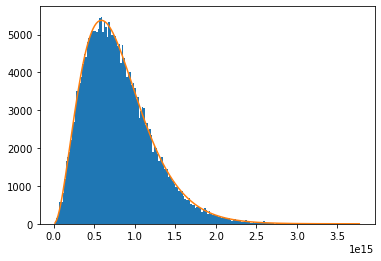

In [7]:
bins=200
nus_planck = np.linspace(min(nus),max(nus),bins)
bin_width = nus_planck[1]-nus_planck[0]

plt.hist(nus,bins=bins,weights=lumin_per_packet/bin_width) #the weights argument is once again to make sure our plotted spectrum has the correct y-axis scale
plt.plot(nus_planck,np.pi*planck_function(nus_planck,temp))
plt.show()

We finally plot the generated $\mu$ density distribution, followed by the generated $\theta=\arccos (\mu)$ density distribution, compared with the respective curves $\rho = 2\mu$ and $\rho = \sin(2\theta)$:

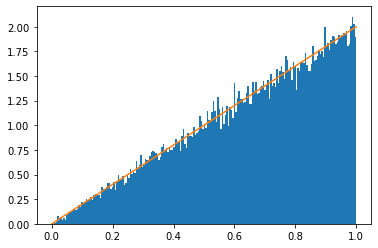

In [8]:
x = np.linspace(0,1,1000)

plt.hist(mus,bins=bins,density=True)
plt.plot(x,2*x)
plt.show()

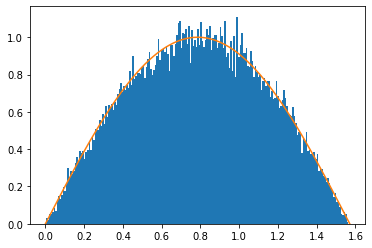

In [9]:
thetas = np.linspace(0,np.pi/2,1000)

plt.hist(np.arccos(mus),bins=bins,density=True)
plt.plot(thetas,np.sin(2*thetas))
plt.show()